In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Data Loading and Preprocessing

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")

In [3]:
train_df.head()

,id,date,likes,content,username,media,inferred company
0,1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
1,2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
2,3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
3,4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
4,6,2020-11-15 16:01:08,525,An 85-year-old primary school in Shanghai has ...,cnni,[Video(thumbnailUrl='https://pbs.twimg.com/amp...,cnn


In [4]:
val_df.head()

,id,date,likes,content,username,media,inferred company
0,7,2019-10-24 10:51:03,0,LASU Celebrates New Dawn Of Unbroken Peace As ...,IndependentNGR,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
1,13,2020-03-01 15:48:46,672,"The US-Taliban agreement, which sets into moti...",CNN,[Video(thumbnailUrl='https://pbs.twimg.com/med...,cnn
2,25,2020-07-19 00:07:00,78,Many people are understandably anxious to get ...,MayoClinic,[Photo(previewUrl='https://pbs.twimg.com/media...,mayo clinic
3,27,2018-09-26 16:42:17,961,ALSO NOW (yes it's wild here today): Sen Merkl...,LisaDNews,[Photo(previewUrl='https://pbs.twimg.com/media...,desjardins
4,39,2020-03-11 20:15:08,4,Toyota Motor North America Chief Diversity Off...,ToyotaSD,[Photo(previewUrl='https://pbs.twimg.com/media...,toyota


In [5]:
test_df.head()

,id,date,likes,content,username,media,inferred company
0,5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
1,12,2020-11-18 00:07:02,0,#NetZeroHomes: learn the best way to get to ze...,MitsubishiHVAC,[Photo(previewUrl='https://pbs.twimg.com/media...,trane
2,23,2018-09-11 14:23:02,120,"Tournaments come and go, but the pictures are ...",GettySport,[Photo(previewUrl='https://pbs.twimg.com/media...,getty images
3,31,2020-11-10 03:00:26,567,Monster Hunter Rise Concept Art: Great Izuchi....,MHinfo_en,[Photo(previewUrl='https://pbs.twimg.com/media...,monster
4,32,2018-11-29 22:11:56,1,"With our #SalesDevelopmentProgram, you'll lear...",UnitedRentals,[Photo(previewUrl='https://pbs.twimg.com/media...,united rentals


In [6]:
val_df = val_df[val_df['likes'] <= 3500]
len(val_df)

28813

In [7]:
val_df = val_df.sample(10000)
len(val_df)

10000

In [8]:
train_content = train_df["content"].values
val_content = val_df["content"].values
train_labels = train_df["likes"].values
val_labels = val_df["likes"].values
test_content = test_df["content"].values
test_labels = test_df["likes"].values

In [9]:
arr = []
for i in range(len(val_labels)):
  if val_labels[i] > 100:
    arr.append(1)
  else: arr.append(0)

In [10]:
val_dates = val_df['date'].values
val_user = val_df['username'].values
val_company = val_df['inferred company'].values
val_text = val_df['content'].values
for i in range(len(val_dates)):
  stri = f"""
  content: {val_text[i]}
  username: {val_user[i]}
  company: {val_company[i]}
  dates: {val_dates[i]}
  """
  val_content[i] = stri

In [11]:
print(val_content[0])


  content: #VSCode is a lightweight but powerful source code editor with built-in support for JavaScript, TypeScript, and #NodeJS. Interested in getting started?

Watch our introductory videos: <hyperlink> <hyperlink>
  username: VisualStudio
  company: microsoft
  dates: 2019-05-03 17:54:01
  


In [12]:
import numpy as np
train_log_labels = []
for i in range(len(train_labels)):
  train_log_labels.append(np.log(1+train_labels[i]))

In [13]:
val_log_labels = []
for i in range(len(val_labels)):
  val_log_labels.append(np.log(1+val_labels[i]))

In [14]:
test_log_labels = []
for i in range(len(test_labels)):
  test_log_labels.append(np.log(1+test_labels[i]))

# RoBERTa Model

In [15]:
class CustomRegressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

criterion = nn.MSELoss()

val_texts = val_content
val_labels = val_log_labels

val_dataset = CustomRegressionDataset(val_texts, val_labels, tokenizer, max_length=128)
val_loader = DataLoader(val_dataset, batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model_classification_1 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])


# Evaluation

In [17]:
filename = "/content/drive/MyDrive/model_classification_1(1).pickle"
classification_model_1 = pickle.load(open(filename, "rb"))

In [18]:
val_labels[:10]

[4.532599493153256,
 5.802118375377063,
 6.710523109452428,
 5.700443573390687,
 0.0,
 4.110873864173311,
 0.6931471805599453,
 0.0,
 1.791759469228055,
 5.231108616854587]

In [20]:
model_log = torch.load('/content/drive/MyDrive/model_log_less_than_100.pth')
model_log_big = torch.load('/content/drive/MyDrive/model_log_greater_than_100_less_than_3500.pth')
model_log.to(device)
model_log_big.to(device)

cnt = 0
ans = []

model_log.eval()
model_log_big.eval()

val_loss = 0.0
with torch.no_grad():
    for batch in val_loader:
        cnt += 1
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        class_label = classification_model_1.predict([val_content[cnt-1]])[0]
        if class_label == 0: outputs = model_log(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        else: outputs = model_log_big(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        ans.extend(outputs.logits)
        loss = outputs.loss

        val_loss += loss.item()
        print(cnt)

average_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {average_val_loss}")

Streaming output truncated to the last 5000 lines.
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191

In [21]:
len(ans)

10000

In [22]:
ans

[tensor([4.5541], device='cuda:0'),
 tensor([5.8980], device='cuda:0'),
 tensor([4.3794], device='cuda:0'),
 tensor([5.9743], device='cuda:0'),
 tensor([1.0255], device='cuda:0'),
 tensor([4.4603], device='cuda:0'),
 tensor([0.1160], device='cuda:0'),
 tensor([0.1355], device='cuda:0'),
 tensor([1.0882], device='cuda:0'),
 tensor([4.4301], device='cuda:0'),
 tensor([5.9295], device='cuda:0'),
 tensor([5.8324], device='cuda:0'),
 tensor([6.0370], device='cuda:0'),
 tensor([7.2360], device='cuda:0'),
 tensor([0.1379], device='cuda:0'),
 tensor([2.7493], device='cuda:0'),
 tensor([6.4969], device='cuda:0'),
 tensor([7.3132], device='cuda:0'),
 tensor([5.7337], device='cuda:0'),
 tensor([0.8481], device='cuda:0'),
 tensor([2.3226], device='cuda:0'),
 tensor([6.8026], device='cuda:0'),
 tensor([5.8614], device='cuda:0'),
 tensor([0.9249], device='cuda:0'),
 tensor([6.1108], device='cuda:0'),
 tensor([3.3002], device='cuda:0'),
 tensor([2.1665], device='cuda:0'),
 tensor([7.6273], device='cu

In [23]:
val_log_labels[:10], ans[:10]

([4.532599493153256,
  5.802118375377063,
  6.710523109452428,
  5.700443573390687,
  0.0,
  4.110873864173311,
  0.6931471805599453,
  0.0,
  1.791759469228055,
  5.231108616854587],
 [tensor([4.5541], device='cuda:0'),
  tensor([5.8980], device='cuda:0'),
  tensor([4.3794], device='cuda:0'),
  tensor([5.9743], device='cuda:0'),
  tensor([1.0255], device='cuda:0'),
  tensor([4.4603], device='cuda:0'),
  tensor([0.1160], device='cuda:0'),
  tensor([0.1355], device='cuda:0'),
  tensor([1.0882], device='cuda:0'),
  tensor([4.4301], device='cuda:0')])

In [26]:
actual_arr = []
for i in range(len(ans)):
  actual_arr.append(math.exp(ans[i][0]))

In [27]:
actual_arr[:10]

[95.01730459322573,
 364.32123898060223,
 79.79012711662621,
 393.17660978438914,
 2.788410075838861,
 86.51481788932563,
 1.1230327254979267,
 1.1450953050363557,
 2.9688635327793675,
 83.94300957231934]

In [28]:
val_labels=val_df['likes'].values
val_labels[:10]

array([ 92, 330, 820, 298,   0,  60,   1,   0,   5, 186])

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(val_labels, actual_arr)
r2score = r2_score(val_labels, actual_arr)

In [30]:
rmse = math.sqrt(mse)

In [31]:
print("RMSE: ", rmse)

RMSE:  408.0958230384896


In [32]:
mse

166542.20078146222

In [33]:
r2score

0.4501791404625731

In [34]:
Z = [x for _, x in sorted(zip(val_labels, actual_arr))]

In [35]:
val_labels_sorted = sorted(val_labels)

In [36]:
x = []
for i in range(len(val_labels)):
  x.append(i)

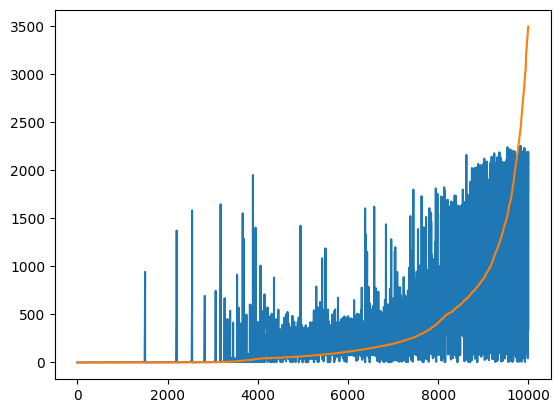

In [37]:
plt.plot(x, Z)
plt.plot(x, val_labels_sorted)